In [1]:
import csv
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import numpy as np
import scipy.spatial.distance
import time
from matplotlib.path import Path

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pyslabgrid import eqcat as eqc
from pyslabgrid import reckoner as reck

deg2km = 111.19492664455873
km2deg = 0.008993216059187306
# DO NOT RUN --- UNLESS YOU NEED TO. 

#### Projecting the events on the interface model
#### WARNING: DO NOT RUN --- UNLESS YOU ABSOLUTELY NEED TO. 


In [2]:
def is_within_interfacezone(evlon, evlat, szone, pbounds=None):
    if pbounds is None:
        finterp_file = {'hik': '../01subduction-model/finterp/hik_finterp.npy',
                    'puy': '../01subduction-model/finterp/puy_finterp.npy'}
        finterp = np.load(finterp_file[szone], allow_pickle=True)[()]
        pbounds = finterp['xbounds']
    if pbounds.contains(Point(evlon, evlat)):
        return True
    return False

# extract events on a profile/box
def get_box(cx,cy, szone=None):
    # 
    halfL = 900*km2deg
    halfW = 50*km2deg   
    x1, y1 = cx+halfL, cy+halfW
    x2, y2 = x1, cy-halfW
    x3, y3 = cx-halfL, y2
    x4, y4 = x3, y1
    bx = [x1,x2,x3,x4,x1]
    by = [y1,y2,y3,y4,y1]
    
    if szone=='hik':
        bx, by = rotate((cx,cy), (bx,by), -10.1)
    else:
        bx, by = rotate((cx,cy), (bx,by), -10.1)
        
    return bx, by
#
def get_inpolygon(X,Y, polygon):
    xs,ys = polygon
    tupVerts = []
    for x,y in zip(xs,ys):
        tupVerts.append((x,y))
    p = Path(tupVerts) # make a polygon

    points = np.vstack((X,Y)).T 
    IN = p.contains_points(points)
    return IN

import math

def rotate(origin, points, angle):
    ox, oy = origin
    qx, qy = [],[]
    pX, pY = points
    for px,py in zip(pX, pY): 
        qx.append(ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy))
        qy.append(oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy))
    return qx, qy

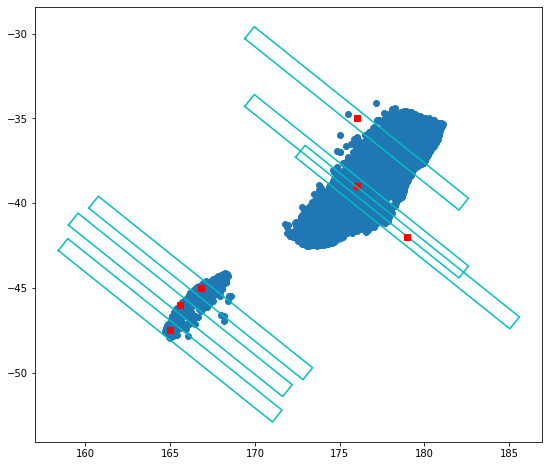

In [3]:
# test the box thing
catalogue = 'NZeqcat_Rollins13042020-subd-slab.csv'
catalogue_folder = '../2event-classifcation/classified_catalogs/'
ecat = eqc.read_slabcatalogue(catalogue_folder+catalogue, remove_depths=[], onlyslab=True)
lon, lat, mag, dep = ecat['lon'], ecat['lat'], ecat['mag'], ecat['dep']

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(lon, lat, 'o')

x, y = 176,-39
ax.plot(x,y,'rs')
bx,by = get_box(x,y, szone='hik')
ax.plot(bx,by, 'c-')

x, y = 176,-35
ax.plot(x,y,'rs')
bx,by = get_box(x,y, szone='hik')
ax.plot(bx,by, 'c')

x, y = 179,-42
ax.plot(x,y,'rs')
bx,by = get_box(x,y, szone='hik')
ax.plot(bx,by, 'c')

x, y = 165.6,-46
ax.plot(x,y,'rs')
bx,by = get_box(x,y, szone='puy')
ax.plot(bx,by, 'c');

x, y = 165,-47.5
ax.plot(x,y,'rs')
bx,by = get_box(x,y, szone='puy')
ax.plot(bx,by, 'c');

x, y = 166.8,-45
ax.plot(x,y,'rs')
bx,by = get_box(x,y, szone='puy')
ax.plot(bx,by, 'c');

ax.set_aspect('equal')

In [4]:
def writeout_proj2midslab(lon, lat, dep, mag, year, szone, fout):
    #
    elat, elon, edep, emag, eyear = [],[],[], [], []
    for x,y,z, m, yr in zip(lon, lat,dep, mag, year):
        if m<3.0:
            continue
        if z>500:
            continue
        if is_within_interfacezone(x, y, szone):
            elon.append(x)
            elat.append(y)
            edep.append(z)
            emag.append(m)
            eyear.append(yr)
            
    finterp_file = {'hik': '../01subduction-model/finterp/hik_finterp.npy',
                    'puy': '../01subduction-model/finterp/puy_finterp.npy'}
    finterp = np.load(finterp_file[szone], allow_pickle=True)[()]
    finterp_strike = finterp['strikeAn']
    
    
    file_midslab =  {'hik': 'grids/hik-midslab_500m_grid.csv', 
                      'puy': 'grids/puy-midslab_500m_grid.csv'}
        
    midslab_rows = []
    with open(file_midslab[szone], mode='r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader)
        for row in csv_reader:
            dep_deg = float(row[2])*km2deg
            midslab_rows.append([float(row[0]), float(row[1]), dep_deg])
    midslab_rows = np.array(midslab_rows)
    
    for x, y, z, m, yr in zip(elon, elat, edep, emag, eyear):
        #
        bx, by = get_box(x,y, szone=szone)
        
        IN = get_inpolygon(midslab_rows[:,0],midslab_rows[:,1],(bx,by))
    
        selected_midslab_rows = np.array(midslab_rows[IN])
        
        # Distance between all pairs of points
        d = scipy.spatial.distance.cdist(selected_midslab_rows, \
                                         np.transpose([[x],[y],[z*km2deg]]))
        dmin = min(d)[0]
        mindx = np.where(d==dmin)[0]
        # slab
        slon, slat = selected_midslab_rows[mindx,0][0], selected_midslab_rows[mindx,1][0]
        sdep = selected_midslab_rows[mindx,2][0]*deg2km
        fout.write('\n%.4f, %.4f, %.4f, %.4f, %d, %.4f, %.4f, %.4f,' \
               %(x,y, z, m, yr, slon, slat, sdep))
        if z < sdep:
            fout.write('%.4f'%(-dmin*deg2km))
        else:
            fout.write('%.4f'%(dmin*deg2km))

In [5]:
catalogues = ['NZeqcat_Rollins13042020-subd-slab.csv', 
              'Grue_NZeqcat_Rollins13042020SepiDeep-subd-slab.csv',
              'Grue_NZeqcat_Rollins13042020SepiShallow_subd-slab.csv']

catalogue_folder = '../2event-classifcation/classified_catalogs/'

out_catalogues = ['NZeqcat_Rollins13042020-subd-slab-proj2midslab.csv',
                 'Grue_NZeqcat_Rollins13042020SepiDeep-subd-slab-proj2midslab.csv',
                 'Grue_NZeqcat_Rollins13042020SepiShallow_subd-slab-proj2midslab.csv']

out_folder = 'projected_catalogs/'

for catalog, out_catalog in zip(catalogues, out_catalogues):
    ecat = eqc.read_slabcatalogue(catalogue_folder+catalog, remove_depths=[], onlyslab=True)
    lon, lat, mag, dep = ecat['lon'], ecat['lat'], ecat['mag'], ecat['dep']
    year =  ecat['year']
    #
    fout= open(out_folder+out_catalog,'w')
    fout.write('lon,lat, dep, mag, year, slat, slon, sdep, dproj')
    szone = 'puy'
    t = time.time()
    writeout_proj2midslab(lon, lat, dep, mag, year, szone, fout)
    szone = 'hik'
    writeout_proj2midslab(lon, lat, dep, mag, year, szone, fout)
    elapsed = time.time() - t
    #print('time taken:', elapsed)
    fout.close()